In [1]:
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

np.set_printoptions(suppress=True, precision=4)

In [2]:
class Policy(nn.Module):

    def __init__(self, num_classes, lr):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=0) #important param to set --> dim
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = self.softmax(x)
        
        return x

def makePolicyNN(num_actions=2, lr=0.01):
    ''' Initialize the policy class '''
    assert isinstance(num_actions, int) and num_actions>0
    
    return Policy(num_actions, lr)

In [3]:
class PolicyGradient:
    def __init__(self, gamma, N=200, max_steps=500):
        ''' Initialize the cart-pole environment '''
        assert isinstance(gamma, float) and 0.0<gamma<1.0, 'Invalid gamma'
        assert isinstance(N, int) and N>0
        assert isinstance(max_steps, int) and max_steps>0
        
        self.env = gym.make ("CartPole-v1")
        self.gamma = gamma
        self.N = N
        self.max_steps = max_steps
        self.numActions = self.env.action_space.n
        self.num_steps = 0
        self.max_steps_reached = False
    
    def getAction(self, policy_network, state):
        ''' Return an action from a stochastic policy '''
        assert isinstance(state, np.ndarray) and len(state) == 4
        
        state = torch.from_numpy(state).float()
        probs = policy_network(state)
        m = Categorical(probs)
        action = m.sample() #type tensor
        log_prob_of_action = m.log_prob(action) #type tensor
        action = action.item() #extracting value from tensor
        
        assert isinstance(action, int) and action in [0,1]
        
        return action, log_prob_of_action
    
    def runEpisode(self, policy_network):
        ''' Generate [s_t, a_t, r_t] pairs for one episode '''
        
        state = self.env.reset()
        done = False
        rewards, log_prob_of_actions = [], []
        while not(done):
            a, lpa = self.getAction(policy_network, state)
            state, r, done, info = self.env.step(a)
            r = rewards.append(r)
            log_prob_of_actions.append(lpa)
            self.num_steps += 1 #incrementing total number of steps in one iteration
            if self.num_steps >= self.max_steps: #checking
                self.max_steps_reached = True
                break;
        
        return rewards, log_prob_of_actions    
    
    def doReinforcePart1(self, policy_network, verbose=False):
        ''' Improve policy by implementing vanilla version of Reinforce algo '''
        
        gamma = self.gamma
        arr_objective = []
        avg_returns = np.zeros((self.N,))
        num_episodes = np.zeros((self.N,))
        
        for i in range(self.N): #improving policy for "self.N" number of iterations
            n, objective = 0, 0
            
            # Resetting variables
            self.num_steps = 0
            self.max_steps_reached = False
            
            # Looping until a maximum number of steps are taken
            while not(self.max_steps_reached):
                # Run an episode with policy and count number of steps taken
                r, log_prob_of_actions = self.runEpisode(policy_network)
                n += 1 #increasing the episode count by 1
                
                # Calculate discounted return (G_tau) and summation of log probs of actions from the episode
                G_tau = sum([ r[t] * gamma**t for t in range(len(r))])
                sum_lpa = sum(log_prob_of_actions)
                avg_returns[i] += sum(r)
                
                # Calculate objective
                objective += G_tau * sum_lpa
                assert isinstance(objective, torch.Tensor)
            
            avg_returns[i] /= n
            num_episodes[i] = n
            # Updating policy
            policy_network.optimizer.zero_grad()
            objective = -objective/n #averaging objective over n episodes and flipping sign so it does gradient ascent
            objective.backward()
            policy_network.optimizer.step()
            arr_objective.append(objective.item())

            if verbose and (i%20 == 0):
                print('Iteration: {0} \t Objective: {1:.3f} \t Average reward: {2:.3f} \t Num_episodes: {3}'\
                      .format(i, objective, avg_returns[i], num_episodes[i]))

        return policy_network, arr_objective, avg_returns, num_episodes
    
    def doReinforcePart2(self, policy_network, verbose=False):
        ''' Improve policy by implementing an imporved version of Reinforce algo '''
        
        gamma = self.gamma
        arr_objective = []
        avg_returns = np.zeros((self.N,))
        num_episodes = np.zeros((self.N,))
        
        for i in range(self.N): #improving policy for "self.N" number of iterations
            n, objective = 0, 0
            
            # Resetting variables
            self.num_steps = 0
            self.max_steps_reached = False
            
            # Looping until a maximum number of steps are taken
            while not(self.max_steps_reached):
                # Run an episode with policy and count number of steps taken
                r, log_prob_of_actions = self.runEpisode(policy_network)
                n += 1 #increasing the episode count by 1
                
                # Calculate discounted return and summation of log probs of actions from the episode
                T = len(r)
                for t in range(T):
                    future_discounted_return = 0
                    for t_prime in range(t, T):
                        future_discounted_return += r[t_prime] * gamma**(t_prime - t)
                    objective += log_prob_of_actions[t]*future_discounted_return
                # Calculating average reward
                avg_returns[i] += sum(r)

                assert isinstance(objective, torch.Tensor)
            
            avg_returns[i] /= n
            num_episodes[i] = n
            # Updating policy
            policy_network.optimizer.zero_grad()
            objective = -objective/n #averaging objective over n episodes and flipping sign so it does gradient ascent
            objective.backward()
            policy_network.optimizer.step()
            arr_objective.append(objective.item())

            if verbose and (i%20 == 0):
                print('Iteration: {0} \t Objective: {1:.3f} \t Average reward: {2:.3f} \t Num_episodes: {3}'\
                      .format(i, objective, avg_returns[i], num_episodes[i]))
        
        return policy_network, arr_objective, avg_returns, num_episodes

    def doReinforcePart3(self, policy_network, verbose=False):
        ''' Improve policy by implementing an imporved version of Reinforce algo '''
        
        gamma = self.gamma
        arr_objective = []
        avg_returns = np.zeros((self.N,))
        num_episodes = np.zeros((self.N,))
        
        for i in range(self.N): #improving policy for "self.N" number of iterations
            n, objective = 0, 0
            
            # Resetting variables
            self.num_steps = 0
            self.max_steps_reached = False
            g, rewards, lpas = [], [], []
            
            # Looping until a maximum number of steps are taken
            while not(self.max_steps_reached):
                # Run an episode with policy and count number of steps taken
                r, log_prob_of_actions = self.runEpisode(policy_network)
                n += 1 #increasing the episode count by 1
                rewards.append(r)
                lpas.append(log_prob_of_actions)
                # Calculate modified return and summation of log probs of actions from the episode
                T = len(r)
                for q in range(T):
                    modified_return = 0
                    for t in range(q, T):
                        modified_return += r[q]*gamma**(t-q)
                    g.append(modified_return)
            
            assert len(g) == self.num_steps, 'Length of g ({0}) == number of steps ({1})'.format(len(g), self.num_steps)
            b = np.mean(np.array(g))
            
            for r, log_prob_of_actions in zip(rewards, lpas):
                T = len(r)
                for t in range(T):
                    modified_return = 0
                    for t_prime in range(t, T):
                        modified_return += r[t_prime]*gamma**(t_prime - t)
                    objective += log_prob_of_actions[t]*(modified_return - b)
                # Calculating average returns
                avg_returns[i] += sum(r)
            
            avg_returns[i] /= n
            num_episodes[i] = n
            # Updating policy
            policy_network.optimizer.zero_grad()
            objective = -objective/n #averaging objective over n episodes and flipping sign so it does gradient ascent
            objective.backward()
            policy_network.optimizer.step()
            arr_objective.append(objective.item())

            if verbose and (i%20 == 0):
                print('Iteration: {0} \t Objective: {1:.3f} \t Average reward: {2:.3f} \t Num_episodes: {3}'\
                      .format(i, objective, avg_returns[i], num_episodes[i]))

        return policy_network, arr_objective, avg_returns, num_episodes

# Need to calculate $ J(\theta) \approx 1/N \sum_{i=0}^{N} G(\tau_{i}) \sum_{t=0}^{T} log\pi_{\theta}(a_{t} | s_{t}) $
## $ G(\tau_{i}) = \sum_{t=0}^{T} \gamma^{t}r_{t}$

Iteration: 0 	 Objective: -0.190 	 Average reward: 20.000 	 Num_episodes: 50.0
Iteration: 20 	 Objective: -5.125 	 Average reward: 41.667 	 Num_episodes: 24.0
Iteration: 40 	 Objective: -24.716 	 Average reward: 76.923 	 Num_episodes: 13.0
Iteration: 60 	 Objective: -22.455 	 Average reward: 200.000 	 Num_episodes: 5.0
Iteration: 80 	 Objective: -33.469 	 Average reward: 200.000 	 Num_episodes: 5.0
Iteration: 100 	 Objective: -81.693 	 Average reward: 250.000 	 Num_episodes: 4.0
Iteration: 120 	 Objective: -41.928 	 Average reward: 250.000 	 Num_episodes: 4.0
Iteration: 140 	 Objective: 66.532 	 Average reward: 250.000 	 Num_episodes: 4.0
Iteration: 160 	 Objective: 117.697 	 Average reward: 333.333 	 Num_episodes: 3.0
Iteration: 180 	 Objective: -147.014 	 Average reward: 333.333 	 Num_episodes: 3.0


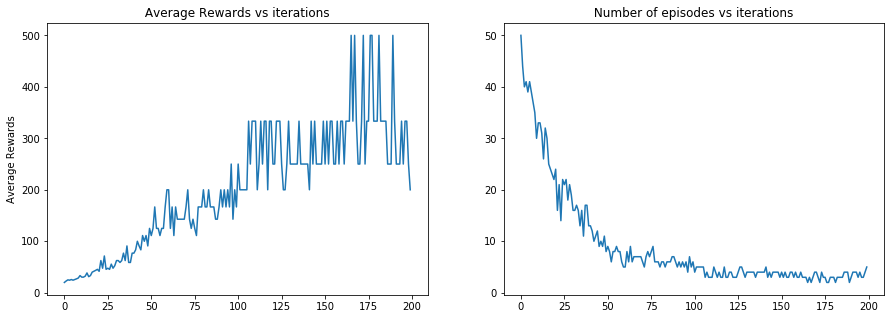

Total steps:  274


In [4]:
if __name__ == '__main__':
    torch.manual_seed(69) #17
    render_env = False
    plot = True
    
    part = 3
    
    if part == 1:
        ## Part 1 (vanilla REINFORCE)
        policy_network = makePolicyNN(num_actions=2, lr=1e-3)
        pg = PolicyGradient(gamma=0.99, N = 200, max_steps=500)
        policy_network, arr_objective, avg_returns, num_episodes = pg.doReinforcePart1(policy_network, verbose=True)
    
    if part == 2:
        ## Part 2 (future discounted returns) 
        policy_network = makePolicyNN(num_actions=2, lr=1e-3)
        pg = PolicyGradient(gamma=0.99, N = 200, max_steps=500)
        policy_network, arr_objective, avg_returns, num_episodes = pg.doReinforcePart2(policy_network, verbose=True)
    
    if part == 3:
        ## Part 3 (future discounted returns - bias) 
        policy_network = makePolicyNN(num_actions=2, lr=1e-3)
        pg = PolicyGradient(gamma=0.99, N = 200, max_steps=500)
        policy_network, arr_objective, avg_returns, num_episodes = pg.doReinforcePart3(policy_network, verbose=True)
    
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(15,5))
        axs = axs.flatten()
        axs[0].plot(avg_returns)
        axs[0].set_ylabel('Average Rewards')
        axs[0].set_title(' Average Rewards vs iterations ')
        axs[1].plot(num_episodes)
        axs[1].set_title(' Number of episodes vs iterations ')
        plt.show()
    
    if render_env:
        steps = 0
        state = pg.env.reset()
        done = False
        while not(done):
            a, _ = pg.getAction(policy_network, state)
            state, r, done, info = pg.env.step(a)
            steps+=1
            pg.env.render()
            time.sleep(0.01)
        print('Total steps: ', steps)
        pg.env.env.close()